In [1]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
B = 0.060 # T for AD
B_ratio=1e-10
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T


beta_x=10 
beta_y=4

disp_x=0.12
#disp_x=0


In [2]:
import xobjects as xo
context = xo.ContextCpu()

num_particles=1
emitt_x=35*1e-6 #inital emittance

x_init=np.sqrt(beta_x*emitt_x)
px_init=np.sqrt(1/beta_x*emitt_x)
y_init=np.sqrt(beta_y*emitt_x)
py_init=np.sqrt(1/beta_y*emitt_x)
delta_init=5e-4*0

particles = xp.Particles(
        
        mass0=mass0,
        p0c=p0c,
        x=x_init,
        px=px_init,
        y=y_init,
        py=py_init,
        delta=delta_init,
        zeta=0)


cooler_xs = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                T_perp=T_perp,T_l=T_l,
                                B=B,B_ratio=B_ratio,
                                Neutralisation_space_charge=0,
                                Neutralisation_rotation=0)

#  # test to_dict / from_dict
# ee=cooler_xs
# dd = ee.to_dict()
# nee = ee.__class__.from_dict(dd, _context=context)
# # Check that the two objects are bitwise identical
# if not isinstance(context, xo.ContextCpu):
#     ee.move(_context=xo.ContextCpu())
#     nee.move(_context=xo.ContextCpu())
# assert (ee._xobject._buffer.buffer[ee._xobject._offset:ee._xobject._size]
#         - nee._xobject._buffer.buffer[
#             nee._xobject._offset:nee._xobject._size]).sum() == 0



# line.build_tracker(_context=context)

num_turns=int(1*1e5)

step=1

#num_turns=int(3*1e6)
#step=1

# initialize arrays
x_xs = []
px_xs = []
py_xs = []
action_x_xs = []
action_y_xs = []
delta_xs = []



for i in tqdm(range(num_turns)):
    
    x_xs.append(particles.x[0])
    px_xs.append(particles.px[0])
    #print('px',particles.px)
    py_xs.append(particles.py[0])
    delta_xs.append(particles.delta[0])

    # calculate action in horizontal plane
    action_x_temp = (particles.x**2/beta_x + beta_x*particles.px**2)
    action_x_xs.append(action_x_temp)
    action_y_temp = (particles.y**2/beta_y + beta_y*particles.py**2)
    action_y_xs.append(action_y_temp)

        

    cooler_xs.track(particles)
    



# convert arrays to numpy arrays
# x_xs = np.concatenate(x_xs)
# px_xs = np.concatenate(px_xs)
# py_xs = np.concatenate(py_xs)

# action_x_xs = np.concatenate(action_x_xs)
# action_y_xs = np.concatenate(action_y_xs)
# delta_xs = np.concatenate(delta_xs)




time = np.arange(0, num_turns, step) * s_per_turn



  0%|          | 0/100000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


  1%|          | 511/100000 [00:02<05:04, 326.84it/s]

Done compiling ContextCpu kernels.


100%|██████████| 100000/100000 [00:17<00:00, 5805.57it/s]


ducktrack

In [3]:
arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )

In [4]:
import ducktrack as dtk
dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=x_init,
        px=px_init,
        y=y_init,
        py=py_init,
        delta=delta_init,
        zeta=0)



dtk_cooler = dtk.elements.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                T_perp=T_perp,T_l=T_l,
                                B=B,B_ratio=B_ratio,
                                Neutralisation_space_charge=0,
                                Neutralisation_rotation=0)

       


# initialize arrays
x = []
px = []
action_x = []
action_y = []
py = []
delta = []


for i in tqdm(range(num_turns)):
    
    x.append(dtk_particle.x)
    px.append(dtk_particle.px)
    py.append(dtk_particle.py)
    delta.append(particles.delta)

    # calculate action in horizontal plane
    action_x_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2)
    action_x.append(action_x_temp)
    action_y_temp = (dtk_particle.y**2/beta_y + beta_y*dtk_particle.py**2)
    action_y.append(action_y_temp)
       
    
        

    #arc.track(dtk_particle)
    dtk_cooler.track(dtk_particle)
    

# convert arrays to numpy arrays
x = np.array(x)
px = np.array(px)
action_x = np.array(action_x)




time = np.arange(0, num_turns, step) * s_per_turn



100%|██████████| 100000/100000 [00:05<00:00, 17626.23it/s]


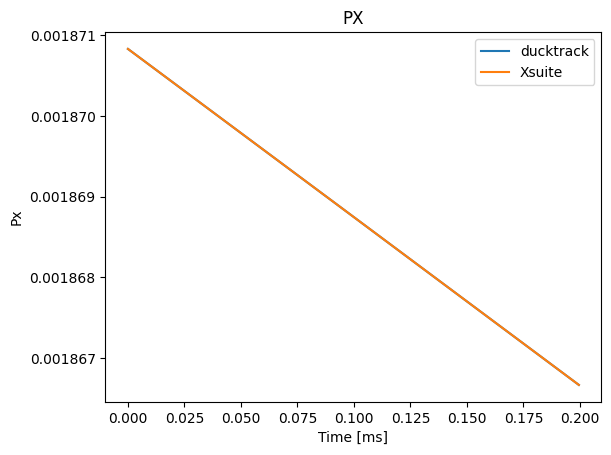

In [5]:
# Plot the horizontal action versus time
plt.figure()

plt.plot(time,px,label='ducktrack')
plt.plot(time,px_xs,label='Xsuite')

plt.xlabel('Time [ms]')
plt.ylabel('Px')
plt.title('PX')
plt.legend()
plt.ticklabel_format(useOffset=False)

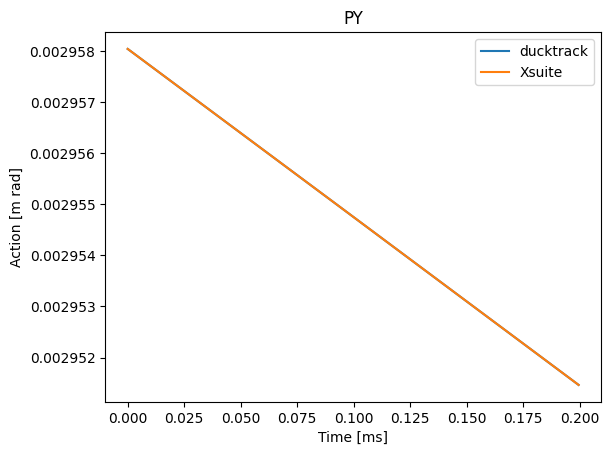

In [6]:
# Plot the horizontal action versus time
plt.figure()

plt.plot(time,py,label='ducktrack')
plt.plot(time,py_xs,label='Xsuite')

plt.xlabel('Time [ms]')
plt.ylabel('Action [m rad]')
plt.title('PY')
plt.legend()
plt.ticklabel_format(useOffset=False)

In [7]:
print(dtk_particle.px)
print(particles.px[0])
# print(dtk_particle.px)
# print(particles.px[0])

0.0018666699385959493
0.0018666699385965404


In [8]:
import xobjects as xo
test_context=xo.ContextCpu()

assert np.isclose(test_context.nparray_from_context_array(particles.x)[0],
                    dtk_particle.x, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.px)[0],
                    dtk_particle.px, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.y)[0],
                    dtk_particle.y, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.py)[0],
                    dtk_particle.py, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.zeta)[0],
                    dtk_particle.zeta, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.delta)[0],
                    dtk_particle.delta, rtol=1e-14, atol=1e-14)

In [9]:
# dtk_particle = dtk.TestParticles(
#         p0c=25.92e9,
#         x=1e-3,
#         px=1e-5,
#         y=-2e-3,
#         py=-1.5e-5,
#         zeta=2.,
#         delta=2E-4)


dtk_particle = dtk.TestParticles(
        mass0=mass0,
        p0c=p0c,
        x=x_init,
        px=px_init,
        y=y_init,
        py=py_init,
        delta=delta_init,
        zeta=0)



particles = xp.Particles.from_dict(dtk_particle.to_dict(),
                                    _context=test_context)
I=2.4
L = 1.5 # m cooler length
r_beam=25*1e-3

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.060 # T for AD
B_ratio=1e-3
Z=1
electron_cooler=xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                                T_perp=T_perp,T_l=T_l,
                                                B=B,B_ratio=B_ratio,
                                                Neutralisation_space_charge=1,Neutralisation_rotation=1)

electron_cooler.track(particles)

dtk_electron_cooler = dtk.elements.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                                T_perp=T_perp,T_l=T_l,
                                                B=B,B_ratio=B_ratio,
                                                Neutralisation_space_charge=1,Neutralisation_rotation=1)

dtk_electron_cooler.track(dtk_particle)


print(dtk_particle.px)
print(particles.px[0])


assert np.isclose(test_context.nparray_from_context_array(particles.x)[0],
                    dtk_particle.x, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.px)[0],
                    dtk_particle.px, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.y)[0],
                    dtk_particle.y, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.py)[0],
                    dtk_particle.py, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.zeta)[0],
                    dtk_particle.zeta, rtol=1e-14, atol=1e-14)
assert np.isclose(test_context.nparray_from_context_array(particles.delta)[0],
                    dtk_particle.delta, rtol=1e-14, atol=1e-14)




0.0018708286917397793
0.0018708286917397793
